In [1]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

np.set_printoptions(threshold=np.inf)
plt.style.use('ggplot')

## ReadDataset

In [2]:
arr = np.genfromtxt('tic-tac-toe.data', delimiter=',', dtype='<U1')

## Split train&test

In [3]:
X = arr[:, :9]
y = arr[:, 9]

X.shape, y.shape

((958, 9), (958,))

## Rotate

In [4]:
X_rotate = []
X_flip_rotate = []

for i in range(4):
    X_matrix = X.reshape(-1, 3, 3)
    X_matrix_flip = np.fliplr(X_matrix)
    for i in range(X_matrix.shape[0]):

        x_rotate = np.rot90(X_matrix[i], i).reshape(-1, 9)
        X_rotate.append(x_rotate)
        
        x_flip_rotate = np.rot90(X_matrix_flip[i], i).reshape(-1, 9)
        X_flip_rotate.append(x_flip_rotate)        
    
a = np.array(X_rotate).reshape(-1, 9)
b = np.array(X_flip_rotate).reshape(-1, 9)
X = np.append(a, b, axis=0)

y = np.tile(y, 8)

X.shape, y.shape

((7664, 9), (7664,))

## Remove Duplicate after rotate

In [5]:
# X, index = np.unique(X, axis=0, return_index=True)
# y = y[index]

# X.shape, y.shape

## LabelEncoder

In [6]:
feature = np.unique(X)
inx = np.arange(feature.shape[0])
search = np.searchsorted(feature, X)
X = inx[search]

uni = np.unique(y)
inx = np.arange(uni.shape[0])
search = np.searchsorted(uni, y)
y = inx[search].reshape(-1, 1)

X.shape, y.shape

((7664, 9), (7664, 1))

## OneHotEncoder

In [7]:
n_feature = feature.shape[0]
one_hot = np.zeros((X.shape[0], X.shape[1], n_feature))
for i, unique_value in enumerate(np.unique(X)):
    one_hot[:, :, i][X == unique_value] = 1

X = one_hot.reshape(-1, n_feature*X.shape[1])

X.shape

(7664, 27)

In [8]:
n_feature = 2
one_hot = np.zeros((y.shape[0], y.shape[1], n_feature))
for i, unique_value in enumerate(np.unique(y)):
    one_hot[:, :, i][y == unique_value] = 1

y = one_hot.reshape(-1, n_feature*y.shape[1])

y.shape

(7664, 2)

## Shuffle

In [9]:
# random_state = 0

# np.random.seed(random_state)
# np.random.shuffle(X)

# np.random.seed(random_state)
# np.random.shuffle(y)

# X.shape, y.shape

## Split

In [10]:
train_size = 0.8
# sample = int(train_split*y.shape[0])

# X_train, X_test = X[:sample], X[sample:]
# y_train, y_test = y[:sample], y[sample:]

# X_train.shape, X_test.shape

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1 -train_size, random_state=42, stratify=y, shuffle=True)

X_train.shape, X_test.shape

((6131, 27), (1533, 27))

## Model

In [12]:
def create_model(neurons=(27, 9), lr=0.06, decay=1e-6, momentum=0.9):
    model = Sequential()

    model.add(Dense(neurons[0], activation='relu', input_shape=(X_train.shape[1:])))
    model.add(Dense(neurons[1], activation='relu'))
    model.add(Dense(2, activation='sigmoid'))

    optimizer = SGD(lr=lr, decay=decay, momentum=momentum, nesterov=True)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

    return model

In [13]:
model = create_model()
model.summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 27)                756       
_________________________________________________________________
dense_1 (Dense)              (None, 9)                 252       
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 20        
Total params: 1,028
Trainable params: 1,028
Non-trainable params: 0
_________________________________________________________________


## Train

In [14]:
batch_size = 16
epochs = 10

history = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_test, y_test))

Train on 6131 samples, validate on 1533 samples
Epoch 1/10
6131/6131 [==============================] - 0s 73us/sample - loss: 0.2165 - acc: 0.9004 - val_loss: 0.0316 - val_acc: 0.9899
Epoch 2/10
6131/6131 [==============================] - 0s 57us/sample - loss: 0.0378 - acc: 0.9873 - val_loss: 0.0244 - val_acc: 0.9905
Epoch 3/10
6131/6131 [==============================] - 0s 56us/sample - loss: 0.0234 - acc: 0.9925 - val_loss: 0.0191 - val_acc: 0.9928
Epoch 4/10
6131/6131 [==============================] - 0s 57us/sample - loss: 0.0207 - acc: 0.9918 - val_loss: 0.0112 - val_acc: 0.9961
Epoch 5/10
6131/6131 [==============================] - 0s 57us/sample - loss: 0.0171 - acc: 0.9937 - val_loss: 0.0096 - val_acc: 0.9935
Epoch 6/10
6131/6131 [==============================] - 0s 55us/sample - loss: 0.0014 - acc: 0.9998 - val_loss: 4.5921e-04 - val_acc: 1.0000
Epoch 7/10
6131/6131 [==============================] - 0s 54us/sample - loss: 3.0626e-04 - acc: 1.0000 - val_loss: 1.5923e-04

## Training accuracy and Training Loss Graph 

Text(0, 0.5, 'Training loss')

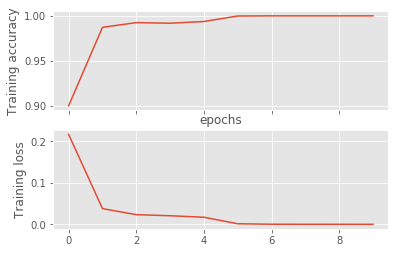

In [15]:
fig, ax = plt.subplots(2, sharex=True)

ax[0].plot(history.history['acc'], label=model)
ax[1].plot(history.history['loss'], label=model)
 
ax[0].set_xlabel('epochs')
ax[0].set_ylabel('Training accuracy')
ax[1].set_ylabel('Training loss')

## Evaluate

In [16]:
score = model.evaluate(X_test, y_test)

1533/1533 [==============================] - 0s 12us/sample - loss: 8.4780e-05 - acc: 1.0000


## Confusion Matrix

In [17]:
y_test_argmax = y_test.argmax(axis=1)
y_pred = model.predict_classes(X_test)
confusion_matrix(y_test_argmax, y_pred)

array([[ 531,    0],
       [   0, 1002]])

In [18]:
def covent_to_matrix(index):
    aaa = X_test[index].reshape(-1, 3).argmax(axis=1).astype('U1')
    for j, unique_value in enumerate(feature):
        aaa[aaa==str(j)] = unique_value

    return aaa.reshape(-1, 3)

In [19]:
x_failed_index = np.where(y_test_argmax != y_pred)[0]
for i in x_failed_index:
    print(f'index {i}, y_test {y_test_argmax[i]}, y_pred {y_pred[i]}')
    print(covent_to_matrix(i))

## Receiver Operating Characteristic

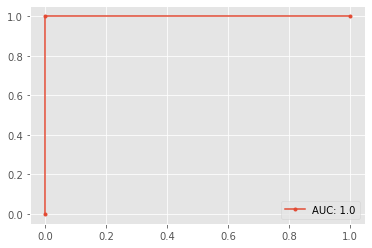

In [20]:
fpr, tpr, _ = roc_curve(y_test_argmax,  y_pred)
auc = roc_auc_score(y_test_argmax, y_pred)

plt.plot(fpr, tpr, marker='.', label=f'AUC: {auc}')
plt.legend()

## GridSearch

In [21]:
param_grid = {
    'neurons' : [(16, 16), (32, 32)],
    'lr' : [0.01, 0.1],
    'momentum' : [0.8, 0.9],
    'batch_size' : [8, 16],
    'epochs' : [40, 60],
}

In [22]:
# model = KerasClassifier(build_fn=create_model, epochs=epochs, batch_size=batch_size, verbose=0)
# grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1)
# grid_result = grid.fit(X_train, y_train)

# print('best score: ', grid_result.best_score_, grid_result.best_params_)

# means = grid_result.cv_results_['mean_test_score']
# stds = grid_result.cv_results_['std_test_score']
# params = grid_result.cv_results_['params']
# for mean, stdev, param in zip(means, stds, params):
#     print(f'{mean} ({stdev}) with: {param}')

## Average test accuracy rate in 12 times

In [23]:
scores = []

for i in range(12):
    model = create_model()
    history = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, verbose=0)
    print(f'Train - loss: {history.history["loss"][-1]} - acc: {history.history["acc"][-1]}')

    score = model.evaluate(X_test, y_test)
    scores.append(score[1])
          
    y_pred = model.predict_classes(X_test)
    x_failed_index = np.where(y_test_argmax != y_pred)[0]
          
    print('index failed:', x_failed_index)
    for i in x_failed_index:
        print(f'index {i}, y_test {y_test_argmax[i]}, y_pred {y_pred[i]}')
        print(covent_to_matrix(i))

scores = np.array(scores)
'Max accuracy rate :', scores.max(), 'Avg accuracy rate :', np.average(scores), 'Min accuracy rate :', scores.min()

Train - loss: 8.649887878864042e-05 - acc: 1.0
1533/1533 [==============================] - 0s 23us/sample - loss: 8.8682e-05 - acc: 1.0000
index failed: []
Train - loss: 8.12868779535553e-05 - acc: 1.0
1533/1533 [==============================] - 0s 23us/sample - loss: 7.7196e-05 - acc: 1.0000
index failed: []
Train - loss: 7.548013920931975e-05 - acc: 1.0
1533/1533 [==============================] - 0s 25us/sample - loss: 7.3639e-05 - acc: 1.0000
index failed: []
Train - loss: 9.601526072603211e-05 - acc: 1.0
1533/1533 [==============================] - 0s 29us/sample - loss: 8.1793e-05 - acc: 1.0000
index failed: []
Train - loss: 9.454216125837708e-05 - acc: 1.0
1533/1533 [==============================] - 0s 28us/sample - loss: 9.3348e-05 - acc: 1.0000
index failed: []
Train - loss: 0.0007604204307135055 - acc: 1.0
1533/1533 [==============================] - 0s 31us/sample - loss: 8.7252e-05 - acc: 1.0000
index failed: []
Train - loss: 0.00011308853291893127 - acc: 1.0
1533/1533 [

('Max accuracy rate :',
 1.0,
 'Avg accuracy rate :',
 1.0,
 'Min accuracy rate :',
 1.0)

## Save Weight

In [24]:
model.save_weights("model.h5")